In [1]:
!pip install yfinance --quiet
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip install scikit-learn --quiet
!pip install tensorflow --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 158.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.0 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
# Parameters
TICKER = "AAPL"        # Change if you want other stock(s)
START = "2010-01-01"
END = datetime.date.today().isoformat()  # up-to-date until running time

In [7]:
df = yf.download(TICKER, start=START, end=END, progress=False)

/tmp/ipython-input-3572965360.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


In [8]:
# Fix multi-index if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip() for col in df.columns]

In [11]:
print(df)
print(df.columns)
print(df.shape)

            Close_AAPL   High_AAPL    Low_AAPL   Open_AAPL  Volume_AAPL
Date                                                                   
2010-01-04    6.418383    6.433078    6.369497    6.400988    493729600
2010-01-05    6.429480    6.465769    6.395590    6.436078    601904800
2010-01-06    6.327212    6.454974    6.320614    6.429482    552160000
2010-01-07    6.315513    6.358101    6.269627    6.350603    477131200
2010-01-08    6.357501    6.358101    6.269928    6.307116    447610800
...                ...         ...         ...         ...          ...
2025-12-01  283.100006  283.420013  276.140015  278.010010     46587700
2025-12-02  286.190002  287.399994  282.630005  283.000000     53669500
2025-12-03  284.149994  288.619995  283.299988  286.200012     43538700
2025-12-04  280.700012  284.730011  278.589996  284.100006     43989100
2025-12-05  278.779999  281.140015  278.049988  280.540009     47244000

[4007 rows x 5 columns]
Index(['Close_AAPL', 'High_AAPL', 'Low_

In [12]:
# Identify columns ending with _AAPL (or any ticker)
renamed = {}
for col in df.columns:
    if col.endswith(f"_{TICKER}"):
        new_col = col.replace(f"_{TICKER}", "")  # remove _AAPL
        renamed[col] = new_col

In [13]:
df = df.rename(columns=renamed)

In [14]:
# If Adj Close missing → create it
if "Adj Close" not in df.columns:
    df["Adj Close"] = df["Close"]

In [15]:
# Keep only OHLCV + Adj Close
df = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]]

In [16]:
print(df.head())
print(df.columns)

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  6.400988  6.433078  6.369497  6.418383   6.418383  493729600
2010-01-05  6.436078  6.465769  6.395590  6.429480   6.429480  601904800
2010-01-06  6.429482  6.454974  6.320614  6.327212   6.327212  552160000
2010-01-07  6.350603  6.358101  6.269627  6.315513   6.315513  477131200
2010-01-08  6.307116  6.358101  6.269928  6.357501   6.357501  447610800
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [17]:
print("Downloaded rows:", df.shape[0])
df.tail()

Downloaded rows: 4007


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-12-01,278.010010,283.420013,276.140015,283.100006,283.100006,46587700
2025-12-02,283.000000,287.399994,282.630005,286.190002,286.190002,53669500
2025-12-03,286.200012,288.619995,283.299988,284.149994,284.149994,43538700
2025-12-04,284.100006,284.730011,278.589996,280.700012,280.700012,43989100
2025-12-05,280.540009,281.140015,278.049988,278.779999,278.779999,47244000


Visualize samples & distributions

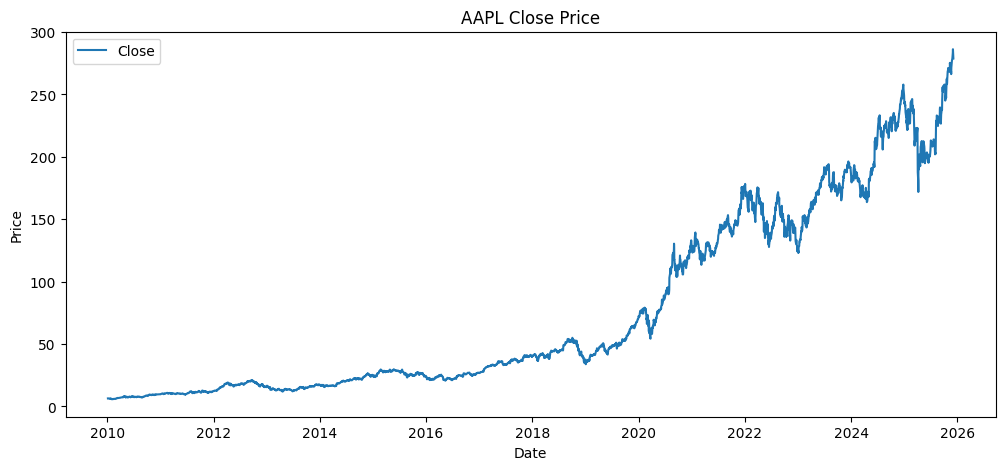

In [19]:
# Plot close price
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Close')
plt.title(f'{TICKER} Close Price')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend()
plt.show()

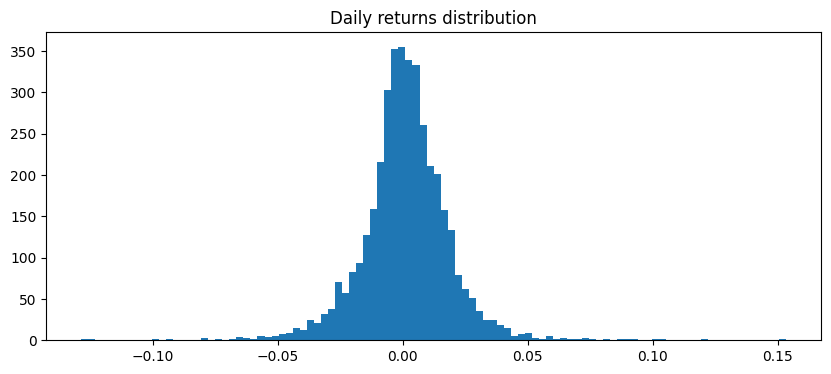

In [20]:
# Histogram of daily returns
df['Return'] = df['Close'].pct_change()
plt.figure(figsize=(10,4))
plt.hist(df['Return'].dropna(), bins=100)
plt.title('Daily returns distribution')
plt.show()

Cleaning

In [21]:
# Check missing values
print(df.isna().sum())

# Forward-fill or drop
df = df.ffill().dropna()
print("After clean:", df.shape)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Return       1
dtype: int64
After clean: (4006, 7)


Preprocessing Pipeline

In [22]:
def create_features_and_labels(data, feature_cols, target_col, window_size=60, horizon=1):
    """
    data: pd.DataFrame (chronological)
    feature_cols: list of columns used as features
    target_col: name of column to predict (single)
    Returns: X (n_windows, window_size, n_features), y (n_windows,)
    """
    values = data[feature_cols].values
    targets = data[target_col].values
    n = len(data)
    X, y = [], []
    for i in range(window_size, n - horizon + 1):
        X.append(values[i-window_size:i])
        y.append(targets[i + horizon - 1])  # predict the closing price at i+horizon-1
    return np.array(X), np.array(y)

In [23]:
# Parameters
WINDOW_SIZE = 60  # previous 60 days
FEATURE_COLS = ['Close']  # can expand to ['Close','Volume','Open',...]
TARGET_COL = 'Close'
HORIZON = 1

In [24]:
# Scale features
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_df[FEATURE_COLS] = scaler.fit_transform(scaled_df[FEATURE_COLS])

In [25]:
X, y = create_features_and_labels(scaled_df, FEATURE_COLS, TARGET_COL, WINDOW_SIZE, HORIZON)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (3946, 60, 1) y shape: (3946,)


In [26]:
# Chronological split
n_samples = len(X)
train_end = int(n_samples * 0.70)
val_end = int(n_samples * 0.85)

In [27]:
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

In [28]:
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (2762, 60, 1) Val: (592, 60, 1) Test: (592, 60, 1)


Model Architecture

In [29]:
def build_lstm_model(window_size, n_features, use_bidirectional=False, units=64, dropout=0.2):
    model = Sequential()
    if use_bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False), input_shape=(window_size, n_features)))
    else:
        model.add(LSTM(units, input_shape=(window_size, n_features)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [30]:
USE_BIDIRECTIONAL = True  # set False to use standard LSTM
n_features = X_train.shape[2]
model = build_lstm_model(WINDOW_SIZE, n_features, use_bidirectional=USE_BIDIRECTIONAL, units=128, dropout=0.2)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,377 (521.00 KB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 0 (0.00 B)

Training Loop

In [31]:
checkpoint_path = "best_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.00065, saving model to best_model.h5


87/87 - 6s - 65ms/step - loss: 8.6350e-04 - root_mean_squared_error: 0.0294 - val_loss: 6.4877e-04 - val_root_mean_squared_error: 0.0255 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss did not improve from 0.00065
87/87 - 4s - 49ms/step - loss: 1.3632e-04 - root_mean_squared_error: 0.0117 - val_loss: 9.0528e-04 - val_root_mean_squared_error: 0.0301 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss did not improve from 0.00065
87/87 - 4s - 47ms/step - loss: 1.2108e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss improved from 0.00065 to 0.00039, saving model to best_model.h5


87/87 - 4s - 44ms/step - loss: 1.1815e-04 - root_mean_squared_error: 0.0109 - val_loss: 3.9478e-04 - val_root_mean_squared_error: 0.0199 - learning_rate: 1.0000e-03
Epoch 5/100

Epoch 5: val_loss did not improve from 0.00039
87/87 - 4s - 45ms/step - loss: 1.0236e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324 - learning_rate: 1.0000e-03
Epoch 6/100

Epoch 6: val_loss improved from 0.00039 to 0.00035, saving model to best_model.h5


87/87 - 4s - 45ms/step - loss: 1.0073e-04 - root_mean_squared_error: 0.0100 - val_loss: 3.5378e-04 - val_root_mean_squared_error: 0.0188 - learning_rate: 1.0000e-03
Epoch 7/100

Epoch 7: val_loss improved from 0.00035 to 0.00031, saving model to best_model.h5


87/87 - 4s - 47ms/step - loss: 8.7838e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.1169e-04 - val_root_mean_squared_error: 0.0177 - learning_rate: 1.0000e-03
Epoch 8/100

Epoch 8: val_loss did not improve from 0.00031

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
87/87 - 4s - 44ms/step - loss: 8.1738e-05 - root_mean_squared_error: 0.0090 - val_loss: 5.4026e-04 - val_root_mean_squared_error: 0.0232 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: val_loss improved from 0.00031 to 0.00028, saving model to best_model.h5


87/87 - 4s - 46ms/step - loss: 7.7475e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.8360e-04 - val_root_mean_squared_error: 0.0168 - learning_rate: 5.0000e-04
Epoch 10/100

Epoch 10: val_loss improved from 0.00028 to 0.00027, saving model to best_model.h5


87/87 - 4s - 45ms/step - loss: 7.9785e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.7183e-04 - val_root_mean_squared_error: 0.0165 - learning_rate: 5.0000e-04
Epoch 11/100

Epoch 11: val_loss did not improve from 0.00027
87/87 - 4s - 45ms/step - loss: 7.7954e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.0383e-04 - val_root_mean_squared_error: 0.0201 - learning_rate: 5.0000e-04
Epoch 12/100

Epoch 12: val_loss improved from 0.00027 to 0.00026, saving model to best_model.h5


87/87 - 4s - 46ms/step - loss: 8.0853e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.5605e-04 - val_root_mean_squared_error: 0.0160 - learning_rate: 5.0000e-04
Epoch 13/100

Epoch 13: val_loss did not improve from 0.00026

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
87/87 - 4s - 51ms/step - loss: 6.5671e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.7133e-04 - val_root_mean_squared_error: 0.0193 - learning_rate: 5.0000e-04
Epoch 14/100

Epoch 14: val_loss improved from 0.00026 to 0.00025, saving model to best_model.h5


87/87 - 4s - 48ms/step - loss: 6.2055e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.5294e-04 - val_root_mean_squared_error: 0.0159 - learning_rate: 2.5000e-04
Epoch 15/100

Epoch 15: val_loss improved from 0.00025 to 0.00025, saving model to best_model.h5


87/87 - 4s - 48ms/step - loss: 6.6083e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.5083e-04 - val_root_mean_squared_error: 0.0158 - learning_rate: 2.5000e-04
Epoch 16/100

Epoch 16: val_loss did not improve from 0.00025
87/87 - 4s - 44ms/step - loss: 6.4050e-05 - root_mean_squared_error: 0.0080 - val_loss: 4.5263e-04 - val_root_mean_squared_error: 0.0213 - learning_rate: 2.5000e-04
Epoch 17/100

Epoch 17: val_loss improved from 0.00025 to 0.00024, saving model to best_model.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
87/87 - 4s - 50ms/step - loss: 7.0531e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.3579e-04 - val_root_mean_squared_error: 0.0154 - learning_rate: 2.5000e-04
Epoch 18/100

Epoch 18: val_loss did not improve from 0.00024
87/87 - 4s - 43ms/step - loss: 6.5553e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.9113e-04 - val_root_mean_squared_error: 0.0222 - learning_rate: 1.2500e-04
Epoch 19/100

Epoch 19: val_loss did not improve from 0.00024
87/87 - 4s - 48ms/step - loss: 5.6446e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.5686e-04 - val_root_mean_squared_error: 0.0160 - learning_rate: 1.2500e-04
Epoch 20/100

Epoch 20: val_loss did not improve from 0.00024
87/87 - 4s - 44ms/step - loss: 5.8036e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.5089e-04 - val_root_mean_squared_error: 0.0158 - learning_rate: 1.2500e-04
Epoch 21/100

Epoch 21: val_loss did not improve from 0.00024

Epoch 21: Red

87/87 - 4s - 44ms/step - loss: 5.3879e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.2690e-04 - val_root_mean_squared_error: 0.0151 - learning_rate: 3.1250e-05
Epoch 28/100

Epoch 28: val_loss did not improve from 0.00023
87/87 - 4s - 43ms/step - loss: 5.2853e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5236e-04 - val_root_mean_squared_error: 0.0159 - learning_rate: 3.1250e-05
Epoch 29/100

Epoch 29: val_loss did not improve from 0.00023

Epoch 29: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
87/87 - 4s - 43ms/step - loss: 6.0759e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.3410e-04 - val_root_mean_squared_error: 0.0153 - learning_rate: 3.1250e-05
Epoch 30/100

Epoch 30: val_loss improved from 0.00023 to 0.00023, saving model to best_model.h5


87/87 - 4s - 45ms/step - loss: 5.8015e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.2572e-04 - val_root_mean_squared_error: 0.0150 - learning_rate: 1.5625e-05
Epoch 31/100

Epoch 31: val_loss did not improve from 0.00023
87/87 - 4s - 45ms/step - loss: 5.5981e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.3870e-04 - val_root_mean_squared_error: 0.0155 - learning_rate: 1.5625e-05
Epoch 32/100

Epoch 32: val_loss did not improve from 0.00023
87/87 - 4s - 44ms/step - loss: 5.4933e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.2691e-04 - val_root_mean_squared_error: 0.0151 - learning_rate: 1.5625e-05
Epoch 33/100

Epoch 33: val_loss did not improve from 0.00023

Epoch 33: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
87/87 - 4s - 44ms/step - loss: 5.6561e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.3031e-04 - val_root_mean_squared_error: 0.0152 - learning_rate: 1.5625e-05
Epoch 34/100

Epoch 34: val_loss did not improve from 0.00023
87/87 - 4s - 4

87/87 - 4s - 43ms/step - loss: 4.8638e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.2445e-04 - val_root_mean_squared_error: 0.0150 - learning_rate: 7.8125e-06
Epoch 36/100

Epoch 36: val_loss did not improve from 0.00022
87/87 - 4s - 43ms/step - loss: 4.8782e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.2751e-04 - val_root_mean_squared_error: 0.0151 - learning_rate: 7.8125e-06
Epoch 37/100

Epoch 37: val_loss did not improve from 0.00022

Epoch 37: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
87/87 - 4s - 44ms/step - loss: 5.7398e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.2878e-04 - val_root_mean_squared_error: 0.0151 - learning_rate: 7.8125e-06
Epoch 38/100

Epoch 38: val_loss did not improve from 0.00022
87/87 - 4s - 43ms/step - loss: 5.2137e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.3439e-04 - val_root_mean_squared_error: 0.0153 - learning_rate: 3.9063e-06
Epoch 39/100

Epoch 39: val_loss did not improve from 0.00022
87/87 - 4s - 4

Training logs visualizations

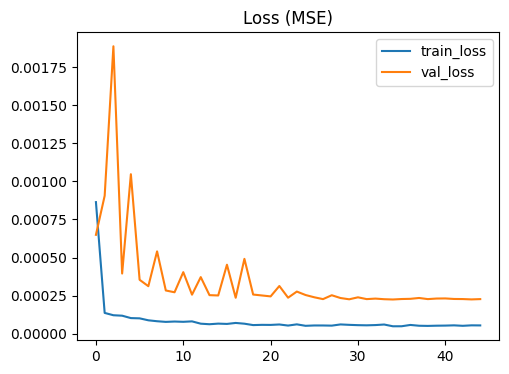

In [33]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss (MSE)')
plt.legend()

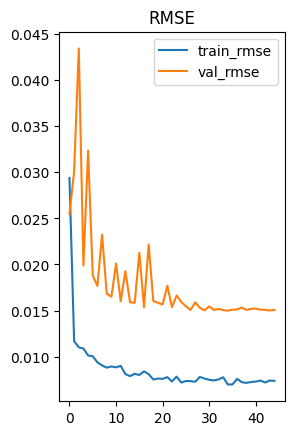

In [34]:
plt.subplot(1,2,2)
plt.plot(history.history['root_mean_squared_error'], label='train_rmse')
plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
plt.title('RMSE')
plt.legend()

plt.show()

Evaluation

In [35]:
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

In [36]:
# Predict
y_pred_scaled = model.predict(X_test).flatten()
# We must inverse transform to get real price scale.
# NOTE: we scaled only the feature column(s). To inverse transform a single column's predictions:
dummy = np.zeros((len(y_pred_scaled), len(FEATURE_COLS)))
dummy[:, 0] = y_pred_scaled  # assigned predicted scaled close into first column
inv_preds = scaler.inverse_transform(dummy)[:,0]

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [37]:
# actuals inverse transform
dummy2 = np.zeros((len(y_test), len(FEATURE_COLS)))
dummy2[:, 0] = y_test
inv_actuals = scaler.inverse_transform(dummy2)[:,0]

In [38]:
# Metrics
rmse = np.sqrt(mean_squared_error(inv_actuals, inv_preds))
mae = mean_absolute_error(inv_actuals, inv_preds)
r2 = r2_score(inv_actuals, inv_preds)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Test RMSE: 6.6373, MAE: 4.8716, R2: 0.9471


Predicted vs Actual plot

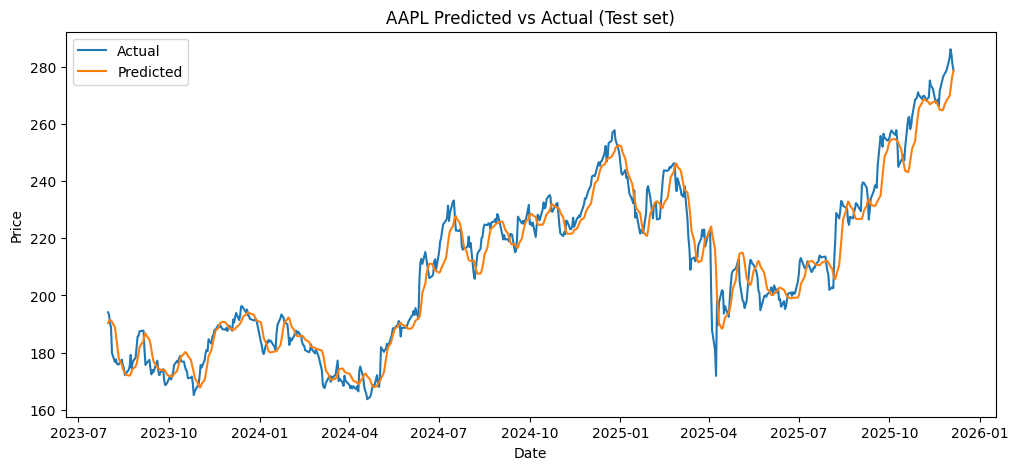

In [39]:
plt.figure(figsize=(12,5))
plt.plot(df.index[-len(inv_actuals):], inv_actuals, label='Actual')
plt.plot(df.index[-len(inv_actuals):], inv_preds, label='Predicted')
plt.title(f'{TICKER} Predicted vs Actual (Test set)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
# Save full model
model.save('lstm_stock_model.h5')
